In [1]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


Using TensorFlow backend.


In [2]:
# import packages### Helper Functions:
import numpy as np
import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# to plot charts and figures
import matplotlib.pyplot as plt
%matplotlib inline


### Global Variables:

In [3]:
rmseStock = {}
upperLimit = 931

### Helper Functions:

In [4]:
# Read the Dataset
def readCSV(filename):
    filename = "Dataset\\" + filename + ".csv"
    df = pd.read_csv(filename)
    df = cleanDate(df)
    return df    


# Changing the date to a standard format [dd-mm-yy]
def cleanDate(df):
    df['Date'] = pd.to_datetime(df.Date,format='%d-%b-%Y')
    df.index = df['Date']
    return df
    

#     Helper function to plot VWAP for stocks
def plotChart(df):
    plt.figure(figsize=(24, 8))
    plt.plot(df['Average Price'], label='VWAP')
    plt.xlabel("Date")
    plt.ylabel("Volume Weighted Average Price")
    plt.legend()
    
    
# Print the entire dataset
def printEntireData(df):
    print(df)
    plotChart(df)
    

# Print a sample of the dataset
def printSampleData(df):
    length = len(df)
    list = [0, 5, 6, 9, 10]
    df1 = df[0:5]
    print(df1[df1.columns[list]])
    print(".\n.\n.")
    df2 = df[987:]
    print(df2[df2.columns[list]])
    print("\nDisplaying 10 out of {} rows.".format(length))


In [5]:
# Creating a smaller dataframe for the model with just two columns Date and Average Price
def createDataFrame(df):
    data = df.sort_index(ascending=True, axis=0)
    dataFrame = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Average Price'])
    
    dataFrame['Date'][i] = data['Date'][i].timestamp()
        
    
    for i in range(0, len(data)):
        dataFrame['Date'][i] = data['Date'][i].timestamp()
        dataFrame['Average Price'][i] = data['Average Price'][i]
#         dataFrame['Open Price'][i] = data['Average Price'][i]
#         dataFrame['Close Price'][i] = data['Average Price'][i]
#         dataFrame['High Price'][i] = data['Average Price'][i]
#         dataFrame['Low Price'][i] = data['Average Price'][i]

    dataFrame.index = dataFrame.Date
    dataFrame.drop('Date', axis=1, inplace=True)
  
    return dataFrame

## RNN (LSTM) model:

<hr>

In [6]:
def LSTMModel(dataFrame, df, stock):
    dataset = dataFrame.values

    train = dataset[:931, :]
    valid = dataset[931:, :]
    
    print("Dataframe created: " + str(len(train)) + " & " + str(len(valid)))
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    x_train, y_train = [], []
    
    for i in range(60, len(train)):
        x_train.append(scaled_data[i-60:i, 0])
        y_train.append(scaled_data[i, 0])
    
    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

    inputs = dataFrame[len(dataFrame) - len(valid) - 60:].values
    inputs = inputs.reshape(-1, 1)
    inputs  = scaler.transform(inputs)

    X_test = []
    for i in range(60, inputs.shape[0]):
        X_test.append(inputs[i-60:i, 0])

    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    print("Size of X_test: " + str(len(X_test)))
    
    avgPrice = model.predict(X_test)
    avgPrice = scaler.inverse_transform(avgPrice)
    
    print("Predictions created:" + str(len(avgPrice)))

    LSTMModelError(valid, avgPrice[-60:], stock)
    plotResult(dataFrame, df, train, valid, avgPrice[-60:])
 
    return model

In [7]:
# Generating Root Mean Square Error (RMSE):
def LSTMModelError(valid, avgPrice, stock):
    print(len(valid))
    print(len(avgPrice))
    rms = np.sqrt(np.mean(np.power((valid - avgPrice), 2)))
    print("Root Mean Square Error: {}".format(rms))
    rmseStock[stock] = rms


In [8]:
def plotResult(dataFrame, df, train, valid, avgPrice):
    test = np.empty(shape=(931,1))
    test[:] = np.NaN
    avgPrice = np.append(test, avgPrice)
    
    newData = df.sort_index(ascending=True, axis=0)
    newDataFrame = pd.DataFrame(index = range(0, len(df)), columns=['Date', 'Predictions'])
    
    for i in range(0, len(newData)):
        newDataFrame['Date'][i] = newData['Date'][i].timestamp()
        newDataFrame['Predictions'][i] = avgPrice[i]
        
    newDataFrame.index = newDataFrame.Date
    newDataFrame.drop('Date', axis=1, inplace=True)


    train = dataFrame[:931]
    valid = dataFrame[931:]

    print("len(newDataFrame)")
    print(len(newDataFrame["Predictions"]))

    print("len(train)")
    print(len(train))
    
    print("len(valid)")
    print(len(valid))

    plt.figure(figsize=(24, 10))
#     plt.plot(train['Average Price'], label = "Training Data VWAP")
    plt.plot(valid['Average Price'], label = "Validation Data VWAP")
    plt.plot(newDataFrame["Predictions"], label = "Predicted VWAP")

    plt.title(stock, fontsize = 18)
    plt.legend()

## Implementation of RNN(LSTM) model:

<hr>

            Symbol  High Price  Low Price  Average Price   Volume
Date                                                             
2015-04-13  BIOCON      491.80     468.15         481.59  2337764
2015-04-15  BIOCON      495.70     474.45         486.89  1367669
2015-04-16  BIOCON      482.40     463.00         470.99   917630
2015-04-17  BIOCON      476.25     463.25         470.79   644312
2015-04-20  BIOCON      469.90     445.40         456.25  1160262
.
.
.
            Symbol  High Price  Low Price  Average Price   Volume
Date                                                             
2019-04-05  BIOCON      615.75     610.10         612.58   622322
2019-04-08  BIOCON      616.50     605.50         609.09   769326
2019-04-09  BIOCON      619.90     603.55         614.15  1624259
2019-04-10  BIOCON      636.75     613.80         627.68  2419841

Displaying 10 out of 991 rows.
Applying LSTM on: BIOCON
Dataframe created: 931 & 60


C:\Users\Kanishk\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 335s - loss: 0.0082
Size of X_test: 931
Predictions created:931
60
60
Root Mean Square Error: 23.03215427786464
len(newDataFrame)
991
len(train)
0
len(valid)
991
               Symbol  High Price  Low Price  Average Price  Volume
Date                                                               
2015-04-13  BRITANNIA      2320.0    2269.55        2296.01  277352
2015-04-15  BRITANNIA      2377.8    2316.00        2356.08  207468
2015-04-16  BRITANNIA      2375.0    2290.25        2325.80  161860
2015-04-17  BRITANNIA      2328.0    2295.00        2301.15  113874
2015-04-20  BRITANNIA      2330.0    2150.00        2188.55  262487
.
.
.
               Symbol  High Price  Low Price  Average Price  Volume
Date                                                               
2019-04-09  BRITANNIA     2988.75     2942.5        2963.00  350181
2019-04-10  BRITANNIA     2995.00     2951.3        2964.52  377556
2019-04-11  BRITANNIA     2974.05     2940.0        2951.74  276801
201

C:\Users\Kanishk\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 372s - loss: 0.0053
Size of X_test: 931
Predictions created:931
60
60
Root Mean Square Error: 75.90275605033202
len(newDataFrame)
991
len(train)
0
len(valid)
991
               Symbol  High Price  Low Price  Average Price   Volume
Date                                                                
2015-04-13  COALINDIA      395.70     383.80         391.38  2909461
2015-04-15  COALINDIA      391.70     384.00         387.48  4149634
2015-04-16  COALINDIA      386.05     381.60         383.62  2034424
2015-04-17  COALINDIA      385.15     379.05         381.81  2106426
2015-04-20  COALINDIA      382.75     370.55         374.19  3400318
.
.
.
               Symbol  High Price  Low Price  Average Price   Volume
Date                                                                
2019-04-05  COALINDIA       236.2      233.7         234.73  3044309
2019-04-08  COALINDIA       236.2      231.6         233.66  4374595
2019-04-09  COALINDIA       239.5      232.3         236.70 

C:\Users\Kanishk\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 386s - loss: 0.0034
Size of X_test: 931
Predictions created:931
60
60
Root Mean Square Error: 9.856564435650862
len(newDataFrame)
991
len(train)
0
len(valid)
991
               Symbol  High Price  Low Price  Average Price  Volume
Date                                                               
2015-04-13  EICHERMOT     16231.0   16001.00       16123.94   43662
2015-04-15  EICHERMOT     16120.0   15810.00       15940.67   44445
2015-04-16  EICHERMOT     16240.0   15734.00       16007.99  108100
2015-04-17  EICHERMOT     15875.0   15199.95       15500.59   57568
2015-04-20  EICHERMOT     15310.0   14630.00       14789.72   90233
.
.
.
               Symbol  High Price  Low Price  Average Price  Volume
Date                                                               
2019-04-10  EICHERMOT     21080.0   20650.00       20911.80   83550
2019-04-11  EICHERMOT     21073.9   20810.40       20980.04   97645
2019-04-12  EICHERMOT     21430.0   20905.05       21131.52  130351
201

C:\Users\Kanishk\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 374s - loss: 0.0062
Size of X_test: 931
Predictions created:931
60
60
Root Mean Square Error: 728.1043045625195
len(newDataFrame)
991
len(train)
0
len(valid)
991
                Symbol  High Price  Low Price  Average Price  Volume
Date                                                                
2015-04-13  HEIDELBERG       80.85      78.35          79.99  189183
2015-04-15  HEIDELBERG       81.75      78.05          79.86  201172
2015-04-16  HEIDELBERG       79.50      77.50          78.31  124294
2015-04-17  HEIDELBERG       78.40      74.60          75.84  198961
2015-04-20  HEIDELBERG       75.45      70.70          72.05  374017
.
.
.
                Symbol  High Price  Low Price  Average Price  Volume
Date                                                                
2019-04-05  HEIDELBERG       183.4     179.05         181.56  277564
2019-04-08  HEIDELBERG       182.4     179.05         180.81  157441
2019-04-09  HEIDELBERG       181.0     175.90         177.60

C:\Users\Kanishk\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 374s - loss: 0.0058
Size of X_test: 931
Predictions created:931
60
60
Root Mean Square Error: 11.79794104495032
len(newDataFrame)
991
len(train)
0
len(valid)
991
               Symbol  High Price  Low Price  Average Price    Volume
Date                                                                 
2015-04-13  ICICIBANK      319.90     316.00         317.58   8009699
2015-04-15  ICICIBANK      322.30     313.05         319.49  10270686
2015-04-16  ICICIBANK      316.00     310.15         312.63   8802458
2015-04-17  ICICIBANK      314.95     308.25         310.21  10581425
2015-04-20  ICICIBANK      317.60     308.30         313.50  10603355
.
.
.
               Symbol  High Price  Low Price  Average Price    Volume
Date                                                                 
2019-04-05  ICICIBANK      392.50     385.60         388.82  10853927
2019-04-08  ICICIBANK      391.45     385.00         388.41   6305407
2019-04-09  ICICIBANK      398.35     387.15     

C:\Users\Kanishk\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 374s - loss: 0.0045
Size of X_test: 931
Predictions created:931
60
60
Root Mean Square Error: 9.32584495095426
len(newDataFrame)
991
len(train)
0
len(valid)
991
           Symbol  High Price  Low Price  Average Price    Volume
Date                                                             
2015-04-13    ITC      352.40     344.85         349.79   7261102
2015-04-15    ITC      358.60     351.40         355.68  11661496
2015-04-16    ITC      356.40     346.65         351.14   5243825
2015-04-17    ITC      353.25     347.70         351.60   5871559
2015-04-20    ITC      352.10     340.60         345.57   7517021
.
.
.
           Symbol  High Price  Low Price  Average Price    Volume
Date                                                             
2019-04-10    ITC      296.55      293.5         295.11   5334642
2019-04-11    ITC      297.45      293.0         295.33  10764968
2019-04-12    ITC      307.40      295.6         302.46  21818291
2019-04-13    ITC      307.4

C:\Users\Kanishk\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 378s - loss: 0.0100
Size of X_test: 931
Predictions created:931
60
60
Root Mean Square Error: 4.6044800535784844
len(newDataFrame)
991
len(train)
0
len(valid)
991
            Symbol  High Price  Low Price  Average Price  Volume
Date                                                            
2015-04-13  MARUTI      3680.0    3642.75        3659.45  218690
2015-04-15  MARUTI      3729.0    3650.40        3697.64  232802
2015-04-16  MARUTI      3718.7    3662.25        3690.80  206305
2015-04-17  MARUTI      3682.9    3636.35        3660.63   99056
2015-04-20  MARUTI      3648.4    3584.60        3610.07  175033
.
.
.
            Symbol  High Price  Low Price  Average Price  Volume
Date                                                            
2019-04-05  MARUTI     7143.95     7050.0        7102.19  729603
2019-04-08  MARUTI     7150.00     7044.7        7102.35  498374
2019-04-09  MARUTI     7235.00     7080.0        7155.98  741669
2019-04-10  MARUTI     7218.95     714

C:\Users\Kanishk\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 371s - loss: 0.0052
Size of X_test: 931
Predictions created:931
60
60
Root Mean Square Error: 372.7672773776731
len(newDataFrame)
991
len(train)
0
len(valid)
991
           Symbol  High Price  Low Price  Average Price  Volume
Date                                                           
2015-04-13    PVR       679.8      661.7         669.04   19009
2015-04-15    PVR       675.0      663.0         666.90   16250
2015-04-16    PVR       670.0      654.0         661.50   10192
2015-04-17    PVR       665.0      650.0         656.12   12223
2015-04-20    PVR       660.0      645.0         649.21    8804
.
.
.
           Symbol  High Price  Low Price  Average Price  Volume
Date                                                           
2019-04-05    PVR     1682.05    1655.55        1667.41  281610
2019-04-08    PVR     1699.00    1669.70        1686.32  348832
2019-04-09    PVR     1687.00    1655.00        1671.04  255249
2019-04-10    PVR     1720.65    1670.00        169

C:\Users\Kanishk\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 371s - loss: 0.0048
Size of X_test: 931
Predictions created:931
60
60
Root Mean Square Error: 81.60817408325761
len(newDataFrame)
991
len(train)
0
len(valid)
991
           Symbol  High Price  Low Price  Average Price    Volume
Date                                                             
2015-04-13   SBIN      288.50     283.35         285.79  11985436
2015-04-15   SBIN      294.45     285.95         290.52  17289500
2015-04-16   SBIN      294.25     286.50         290.52  15043998
2015-04-17   SBIN      294.90     289.20         292.12  16819018
2015-04-20   SBIN      293.35     284.85         289.82  13788536
.
.
.
           Symbol  High Price  Low Price  Average Price    Volume
Date                                                             
2019-04-08   SBIN      319.25      311.1         314.81  17394139
2019-04-09   SBIN      315.70      308.1         311.80  25556039
2019-04-10   SBIN      317.05      310.0         313.54  19237974
2019-04-11   SBIN      315.

C:\Users\Kanishk\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 370s - loss: 0.0053
Size of X_test: 931
Predictions created:931
60
60
Root Mean Square Error: 9.127175714683828
len(newDataFrame)
991
len(train)
0
len(valid)
991


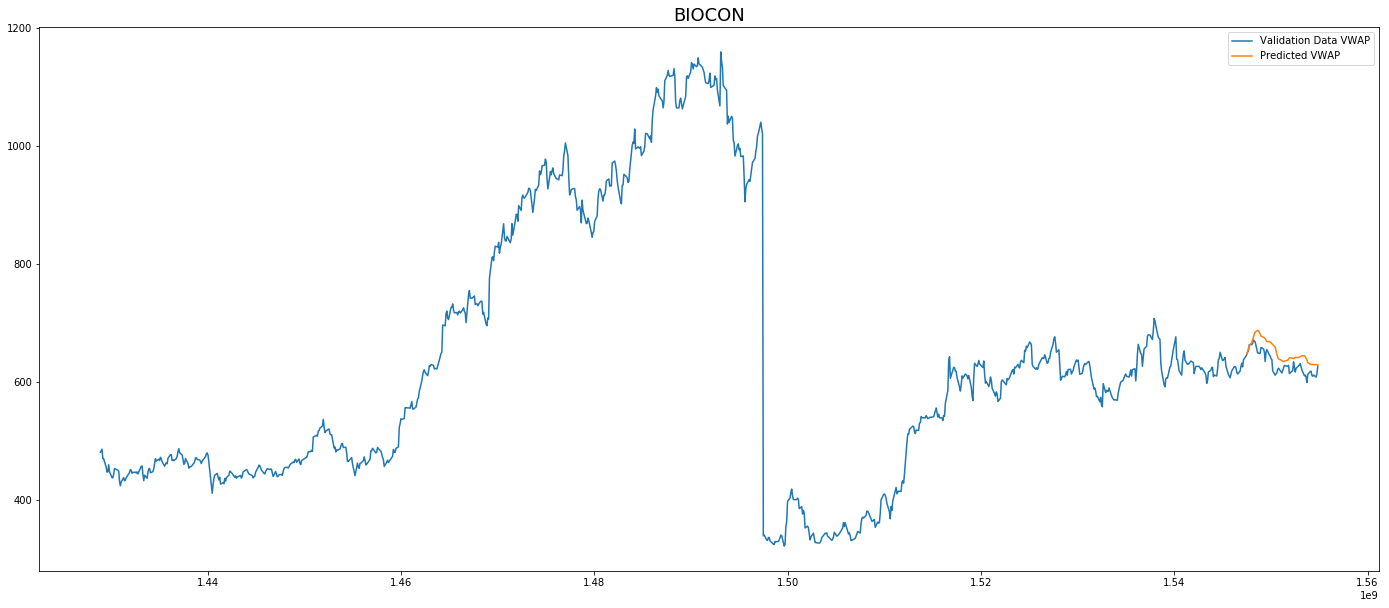

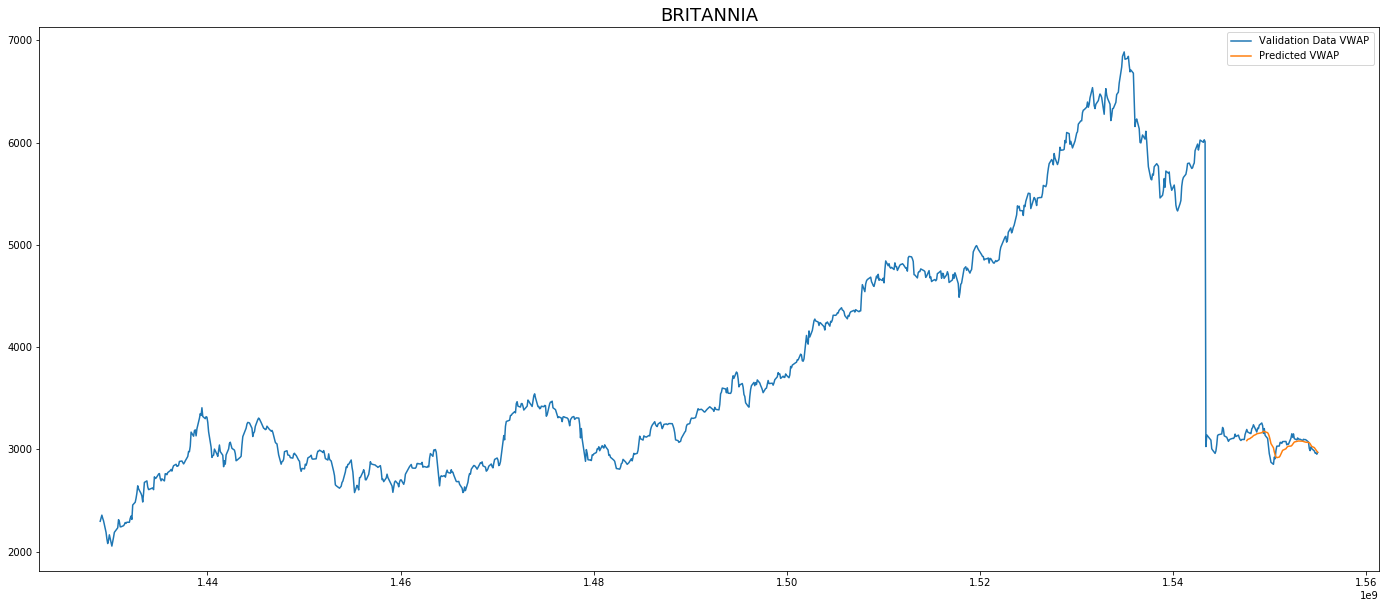

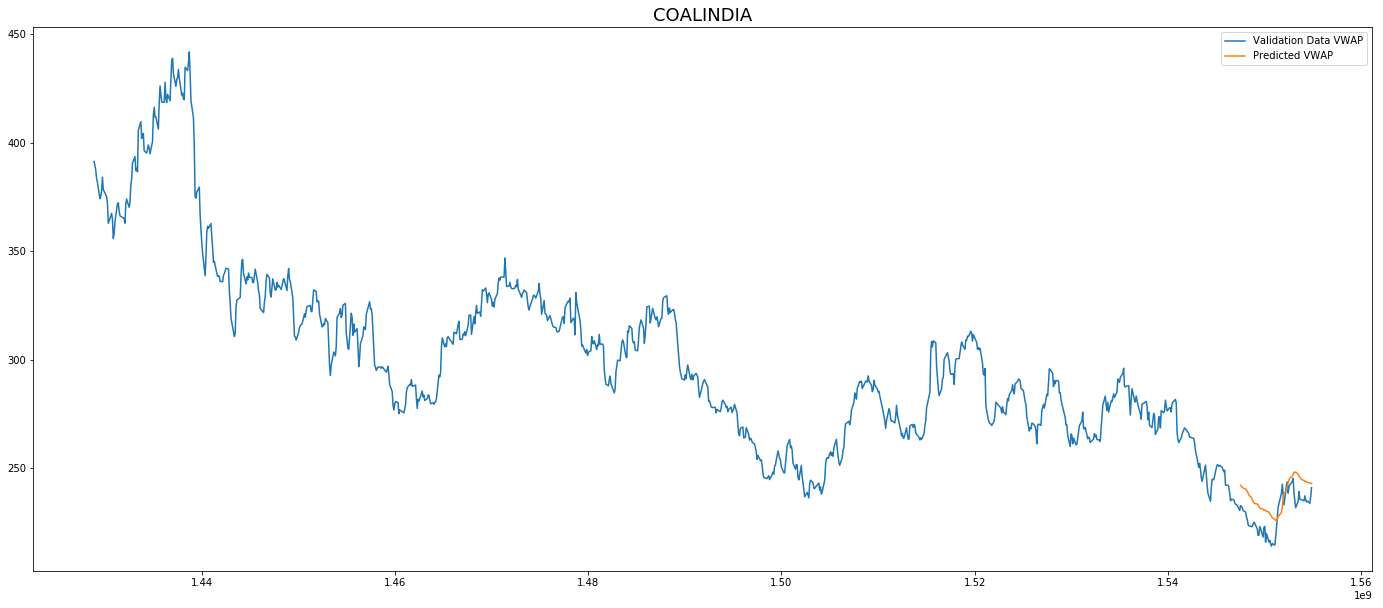

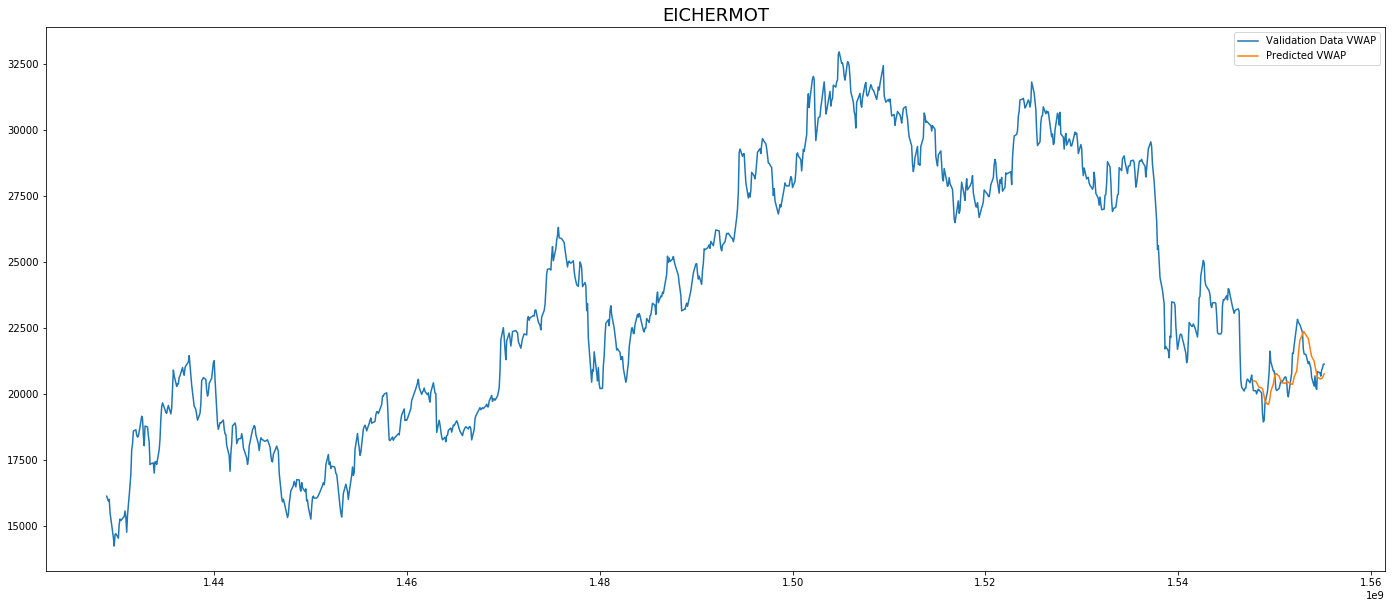

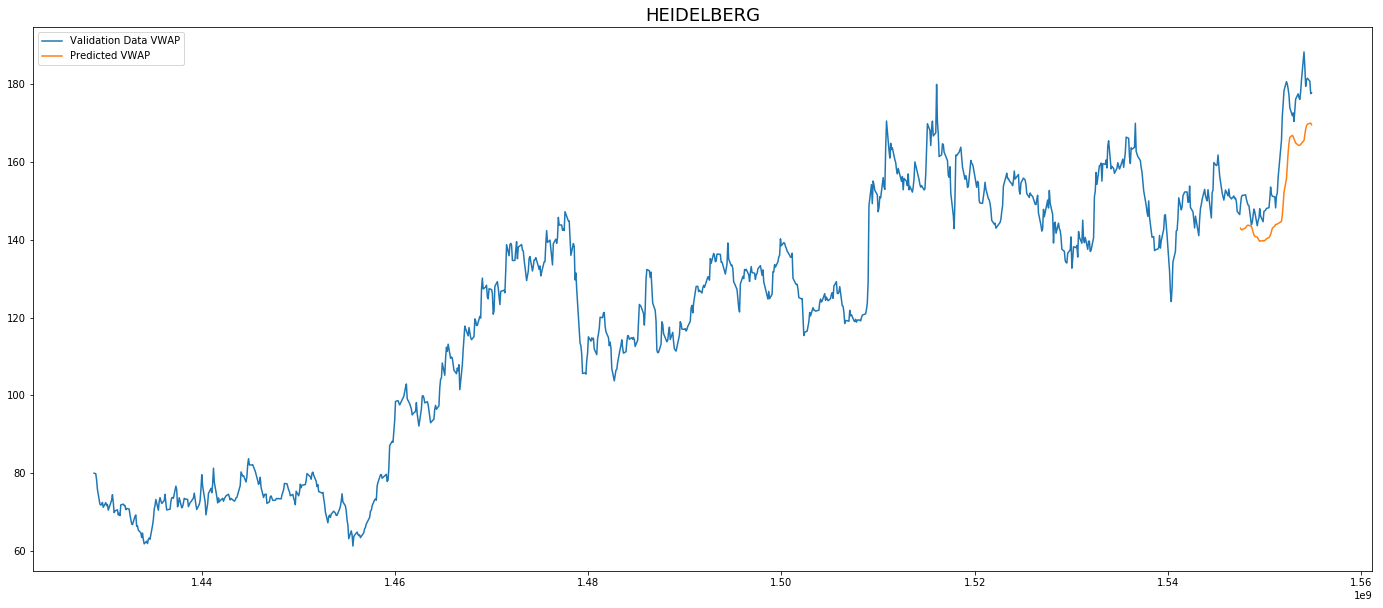

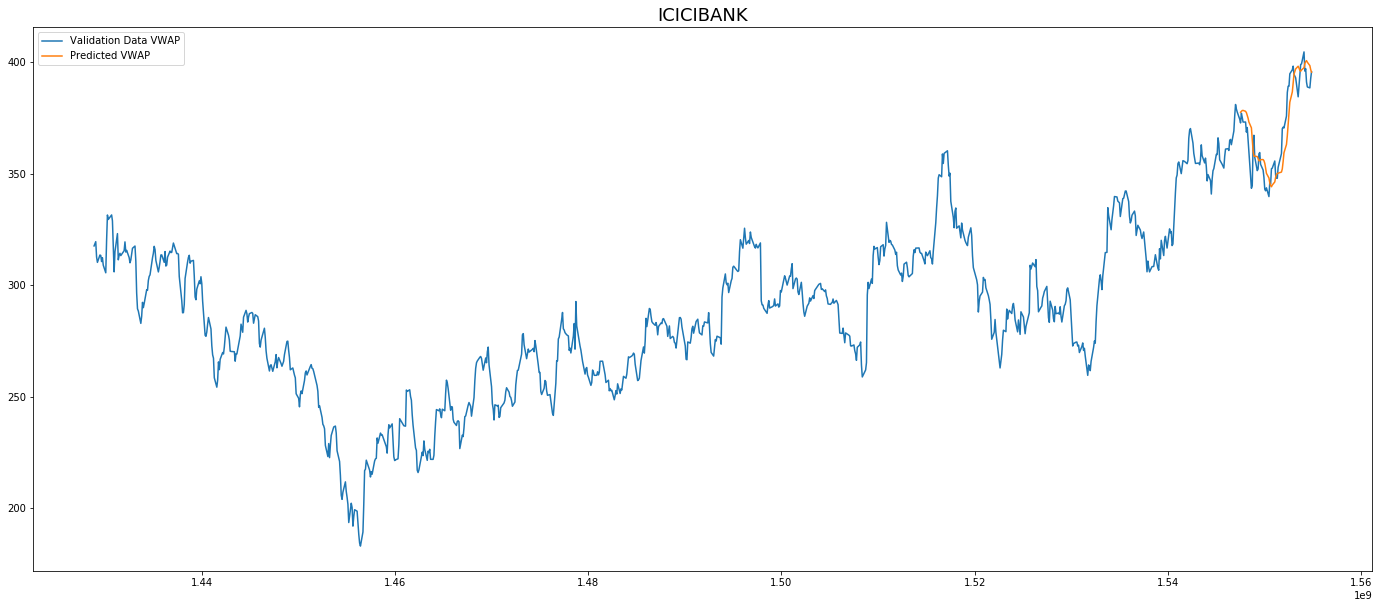

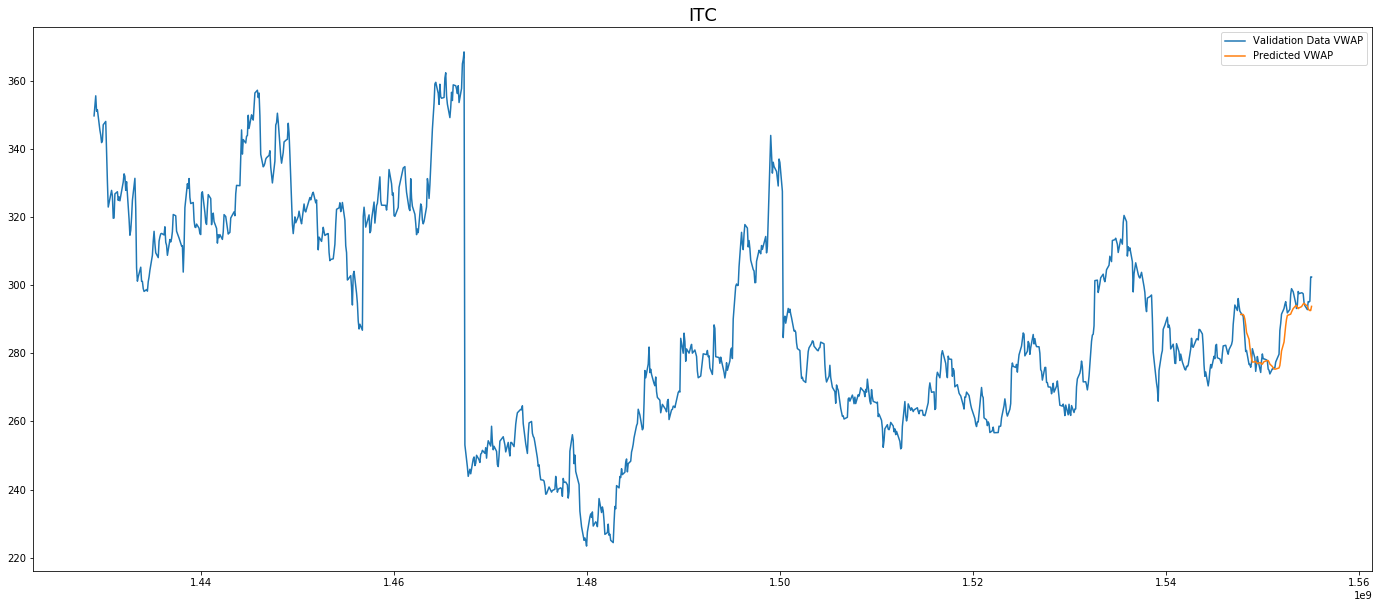

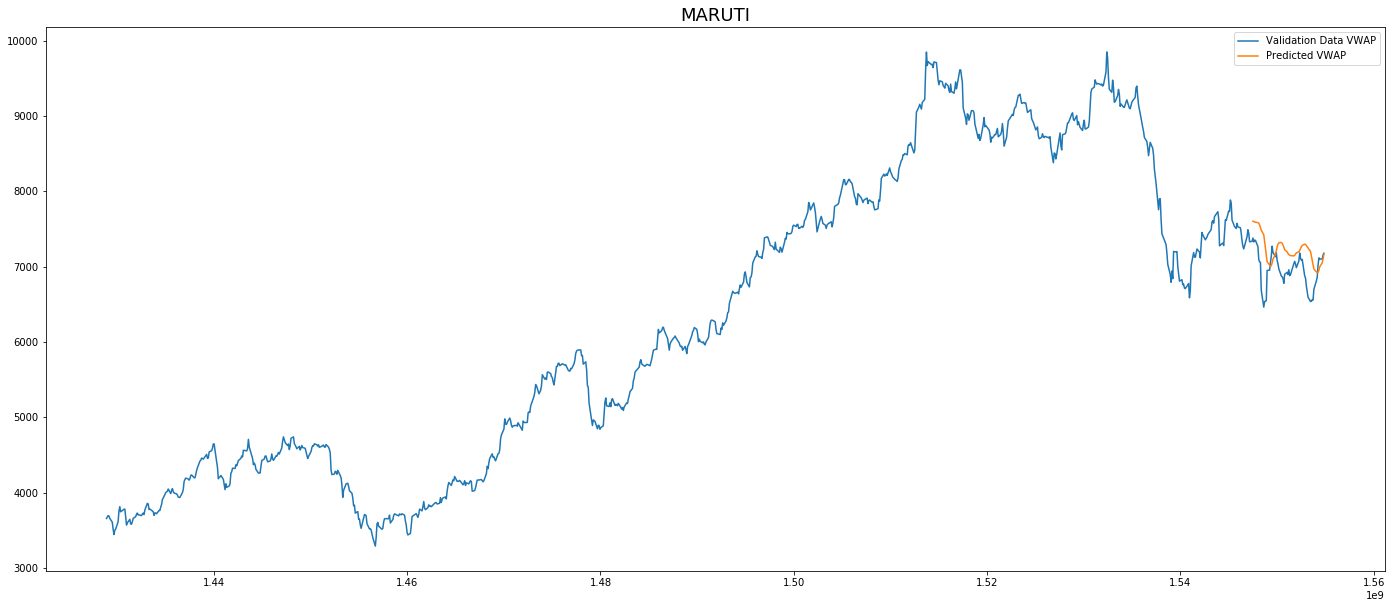

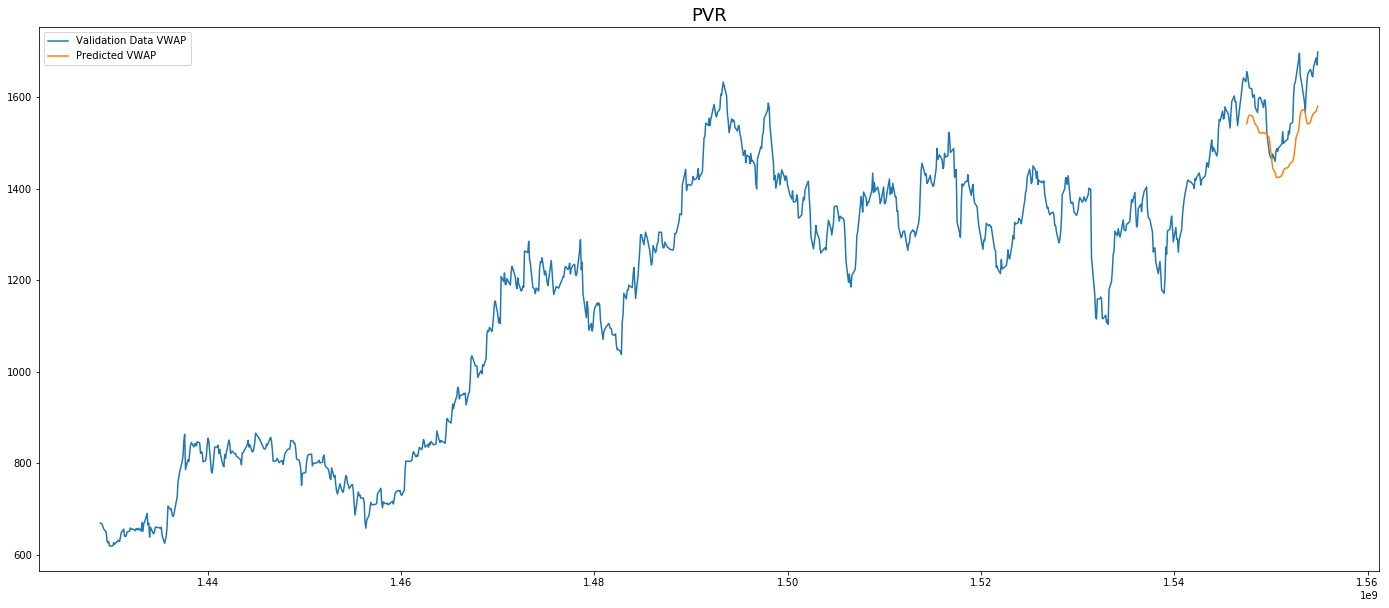

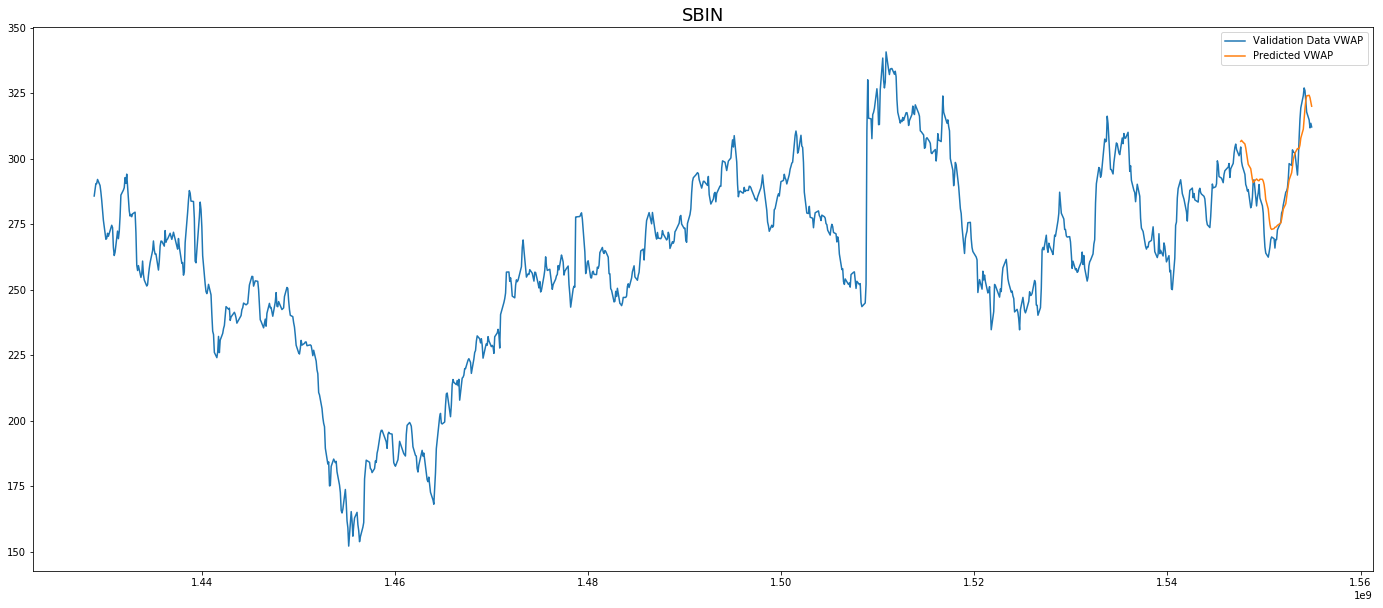

In [9]:
stockList = ['BIOCON', 'BRITANNIA', 'COALINDIA', 'EICHERMOT', 'HEIDELBERG', 'ICICIBANK', 'ITC', 'MARUTI', 'PVR', 'SBIN']
# stockList = ['BIOCON']

for stock in stockList:
    df = readCSV(stock)
    printSampleData(df)

    # Applying LSTM Model
    print("Applying LSTM on: {}".format(stock))
    dataFrame = createDataFrame(df)
    LSTMModel(dataFrame, df, stock)


BIOCON: 3.669410253292226
BRITANNIA: 2.5555020773333514
COALINDIA: 4.0915585037986135
EICHERMOT: 3.4455841537311063
HEIDELBERG: 6.6351392188011475
ICICIBANK: 2.357213798487036
ITC: 1.5223434680878414
MARUTI: 5.192381202399083
PVR: 4.801582367911322
SBIN: 2.923971076304286


Text(0.5, 1.0, 'Percentage RMS Error')

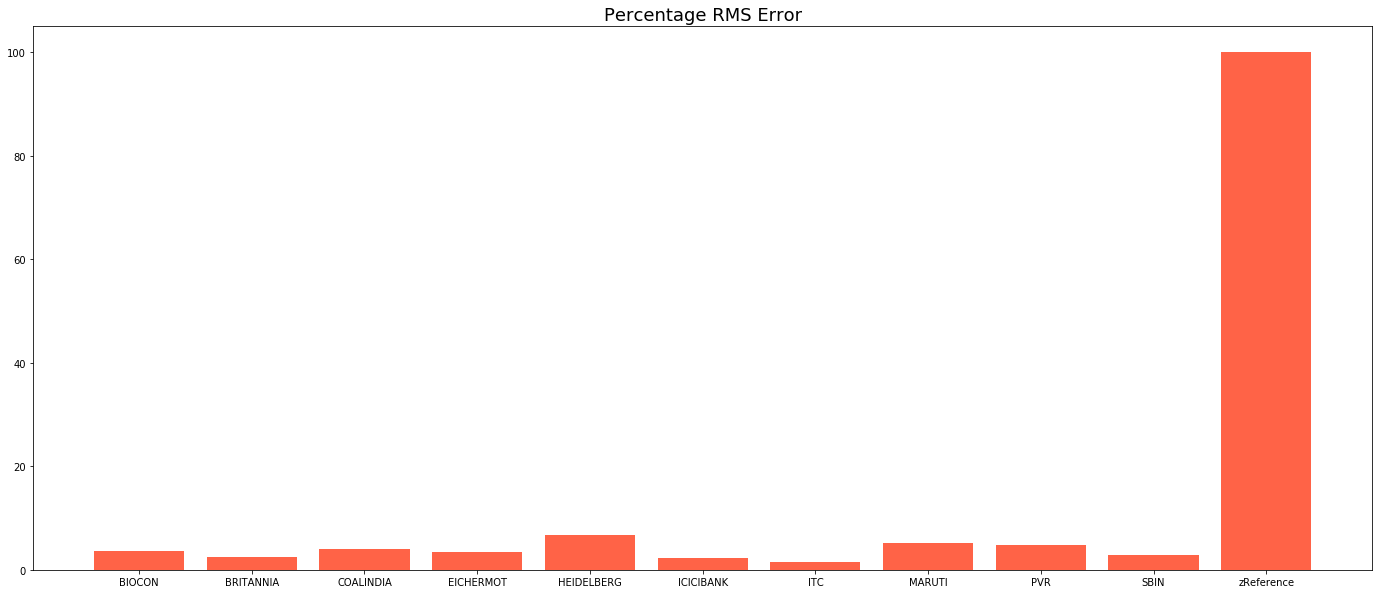

In [10]:
for stock in rmseStock:
    if stock == 'BIOCON':
        rmseStock[stock] = (rmseStock[stock] / 627.68) * 100
        print(stock + ': ' + str(rmseStock[stock]))
    elif stock == 'BRITANNIA':
        rmseStock[stock] = (rmseStock[stock] / 2970.17) * 100
        print(stock + ': ' + str(rmseStock[stock]))
    elif stock == 'COALINDIA':
        rmseStock[stock] = (rmseStock[stock] / 240.90) * 100
        print(stock + ': ' + str(rmseStock[stock]))
    elif stock == 'EICHERMOT':
        rmseStock[stock] = (rmseStock[stock] / 21131.52) * 100
        print(stock + ': ' + str(rmseStock[stock]))
    elif stock == 'HEIDELBERG':
        rmseStock[stock] = (rmseStock[stock] / 177.81) * 100
        print(stock + ': ' + str(rmseStock[stock]))
    elif stock == 'ICICIBANK':
        rmseStock[stock] = (rmseStock[stock] / 395.63) * 100
        print(stock + ': ' + str(rmseStock[stock]))
    elif stock == 'ITC':
        rmseStock[stock] = (rmseStock[stock] / 302.46) * 100
        print(stock + ': ' + str(rmseStock[stock]))
    elif stock == 'MARUTI':
        rmseStock[stock] = (rmseStock[stock] / 7179.12) * 100
        print(stock + ': ' + str(rmseStock[stock]))
    elif stock == 'PVR':
        rmseStock[stock] = (rmseStock[stock] / 1699.61) * 100
        print(stock + ': ' + str(rmseStock[stock]))
    elif stock == 'SBIN':
        rmseStock[stock] = (rmseStock[stock] / 312.15) * 100
        print(stock + ': ' + str(rmseStock[stock]))
   
rmseStock['zReference'] = 100

plt.figure(figsize=(24, 10))    
plt.bar(list(rmseStock.keys()), rmseStock.values(), color='tomato')
plt.title("Percentage RMS Error", fontsize = 18)

# print(rmseStock)